# Project 4. Wrangle and Analyze Data 

## Data wrangling
### - Gathering data

* 1 He descargado en workspaces el archivo **twitter-archive-enhanced.csv** manualmente. 

* 2 Descarga programática utilizando la librería **Request**

In [161]:
import requests
import os

In [162]:
folder_name = 'predictions_dogs'

In [163]:
# Make directory if it doesn't already exist
folder_name = 'predictions_dogs'
if not os.path.exists(folder_name):
    os.makedirs(folder_name,mode=511)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [164]:
with open (os.path.join(folder_name,url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

**COMPROBACIÓN:**

In [165]:
print (os.listdir(folder_name))

['image-predictions.tsv']


* 3 Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting
* 3 El conteo de **retweets de cada tweet y el favorito ("me gusta")** cuentan como mínimo, y cualquier dato adicional que encuentre interesante

In [166]:
import tweepy
import numpy as np
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import pandas as pd
import time
import regex as re

In [167]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'dM5q4kIqwTEoQzOsXpNS4DceY'
consumer_secret = 'vv8pTvVcxJmFvPqDMdAr4za5HXZKUx6X7yDawArkUpNN1lCQs8'
access_token = '1108105912508657664-bVjVh0DrVy2kzKFX2rHcwSabVFzCaz'
access_secret = '0eE6XN86dRE2Fii7mNZoPYPO2RjQKQFJOXPURHVaVRZbZ'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [168]:
# Get the User object for @dog_rates...
user = api.get_user('@dog_rates')

print (user.followers_count)
for friend in user.friends():
   print (friend.screen_name)

7882581
ChronicleBooks
IvePetThatDog
TheVFoundation
FixYourBiz
hess_clint
Summersdale
AndrewsMcMeel
skyhorsepub
dog_feelings
unwise
mackemode
dogfather


In [169]:
df_1 = pd.read_csv('twitter-archive-enhanced.csv')
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

2356

**NOTE:** I charge 'tweet-json.txt' for the Fails and the little time I have

**DataFrame with (at minimum) tweet ID, retweet count, and favorite count**

In [170]:
df = pd.read_json('tweet-json.txt', lines=True)

In [171]:
#read photos dogs
photo_dogs = pd.read_table('predictions_dogs/image-predictions.tsv', sep='\t')

In [172]:
print ('Tweets:',df['id'].count())
print ('Retweets:',df['retweet_count'].sum())
print ('Favorites:', df['favorited'].value_counts())
print ('Sum favorite_count:', df['favorite_count'].sum())

Tweets: 2354
Retweets: 7449933
Favorites: False    2346
True        8
Name: favorited, dtype: int64
Sum favorite_count: 19022600


### - Assessing data
#### **Evaluando datos para este proyecto**
Después de recopilar cada uno de los datos anteriores, evalúelos de forma visual y programática para detectar problemas de calidad y orden. Detecte y documente al menos ocho (8) problemas de calidad y dos (2) problemas de limpieza en su wrangle_act.ipynbportátil Jupyter. Para cumplir con las especificaciones, se deben evaluar los problemas que satisfacen la motivación del proyecto (consulte el encabezado Puntos clave en la página anterior).
#### eight (8) quality issues
- **contributors, coordinates and geo** tienen 0 datos. Se eliminan esas columnas por innecesarias. **OK**
- **created_at** no es necesario que esté en datetime64. Crear 3 columnas con el año, mes y día. **OK**
- Saltos de línea en **full_text**. Eliminar. **OK**
- Aislar el nombre del perro de **full_text**. **OK**
- Extraer la url de **full_text** en otra columna.
- Extraer la votación **full_text** en otra columna.
- **place** tiene solo un registro. Se puede obviar y eliminar columna. **OK**

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [174]:
photo_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [175]:
df['text_split'] = df['full_text'].str.split()

In [176]:
names = []

def extract_names(row):
    # name           
    if 'named' in row['full_text'] and re.match(r'[A-Z].*', row['text_split'][(row['text_split'].index('named') + 1)]): 
            names.append(row['text_split'][(row['text_split'].index('named') + 1)])
    # Here we have 
    elif row['full_text'].startswith('Here we have ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    # This is 
    elif row['full_text'].startswith('This is ') and re.match(r'[A-Z].*', row['text_split'][2]):
            names.append(row['text_split'][2].strip('.').strip(','))
    # Say hello to
    elif row['full_text'].startswith('Say hello to ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    # Meet 
    elif row['full_text'].startswith('Meet ') and re.match(r'[A-Z].*', row['text_split'][1]):
            names.append(row['text_split'][1].strip('.').strip(','))
    else:
        names.append('withoutname')
        
df.apply(extract_names, axis=1)
df['dog_names'] = names

In [177]:
df.drop(['text_split'], axis='columns', inplace = True)
print (df.dog_names.head())
print (df.dog_names.value_counts().head())

0     Phineas
1       Tilly
2      Archie
3       Darla
4    Franklin
Name: dog_names, dtype: object
withoutname    943
Lucy            11
Charlie         11
Oliver          10
Cooper          10
Name: dog_names, dtype: int64


#### Cleaning Data and tidiness issues
#### **Datos de limpieza para este proyecto**
Limpie cada uno de los problemas que documentó al evaluar. Realice esta limpieza wrangle_act.ipynbtambién. El resultado debe ser un DataFrame de pandas maestro de alta calidad y ordenado (o DataFrames, si corresponde). De nuevo, los problemas que satisfacen la Motivación del Proyecto deben ser limpiados.

In [182]:
# Copy the dataframes 
df_clean = df_1.copy()
photo_dogs_clean = photo_dogs.copy()
df_tweet_clean = df.copy()

- Limpiando datos de **df_tweet_clean**

In [183]:
# renombro 'id' para igualarlo con los otros df y lo cambio a str
df_tweet_clean.rename(columns={'id': 'tweet_id'}, inplace=True)
df_tweet_clean.tweet_id = df_tweet_clean.tweet_id.astype(str)

In [184]:
# elimino los retweets
df_tweet_clean.drop(df_tweet_clean[df_tweet_clean['retweeted_status'].notnull()== True].index,inplace=True)

In [185]:
# elimino columnas que no utilizamos, creo año, mes y día y elimino saltos de página en 'full_text'
df_tweet_clean['year'] = df_tweet_clean['created_at'].dt.year
df_tweet_clean['month'] = df_tweet_clean['created_at'].dt.month
df_tweet_clean['day'] = df_tweet_clean['created_at'].dt.day
df_tweet_clean.drop(['contributors',
                     'coordinates',
                     'created_at',
                     'entities',
                     'extended_entities',
                     'favorited',
                     'geo',
                     'id_str',
                     'in_reply_to_screen_name',
                     'in_reply_to_status_id',
                     'in_reply_to_status_id_str',
                     'in_reply_to_user_id',
                     'in_reply_to_user_id_str',
                     'is_quote_status',
                     'lang',
                     'place',
                     'possibly_sensitive',
                     'possibly_sensitive_appealable',
                     'quoted_status',
                     'quoted_status_id',
                     'quoted_status_id_str',
                     'retweeted',
                     'retweeted_status',
                     'source',
                     'truncated',
                     'user'], axis=1,inplace=True)
df_tweet_clean.full_text.replace('\n', ' ')
df_tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2353
Data columns (total 9 columns):
display_text_range    2175 non-null object
favorite_count        2175 non-null int64
full_text             2175 non-null object
tweet_id              2175 non-null object
retweet_count         2175 non-null int64
dog_names             2175 non-null object
year                  2175 non-null int64
month                 2175 non-null int64
day                   2175 non-null int64
dtypes: int64(5), object(4)
memory usage: 169.9+ KB


- Limpiando datos de **photo_dogs_clean**

In [187]:
photo_dogs_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1512,786363235746385920,https://pbs.twimg.com/media/Cum5LlfWAAAyPcS.jpg,1,golden_retriever,0.929266,True,Labrador_retriever,0.062867,True,Saluki,0.002157,True
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1556,793210959003287553,https://pbs.twimg.com/media/CwINKJeW8AYHVkn.jpg,1,doormat,0.874431,False,French_bulldog,0.018759,True,Boston_bull,0.015134,True
933,703356393781329922,https://pbs.twimg.com/media/CcLS6QKUcAAUuPa.jpg,1,Border_collie,0.894842,True,collie,0.097364,True,English_springer,0.003037,True
923,702276748847800320,https://pbs.twimg.com/media/Cb78-nOWIAENNRc.jpg,1,Boston_bull,0.697303,True,French_bulldog,0.239015,True,American_Staffordshire_terrier,0.019838,True


In [189]:
# sustituyo '_' por ' '
photo_dogs_clean['p1'] = photo_dogs_clean['p1'].str.replace('_', ' ')
photo_dogs_clean['p2'] = photo_dogs_clean['p2'].str.replace('_', ' ')
photo_dogs_clean['p3'] = photo_dogs_clean['p3'].str.replace('_', ' ')
photo_dogs_clean['p1'] = photo_dogs_clean['p1'].str.title()
photo_dogs_clean['p2'] = photo_dogs_clean['p2'].str.title()
photo_dogs_clean['p3'] = photo_dogs_clean['p3'].str.title()

In [190]:
# Cambio tweet_id a object para igualarlo con los otros df
photo_dogs_clean.tweet_id = photo_dogs_clean.tweet_id.astype(str)
photo_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


- Limpiando datos de **df_clean**

In [112]:
# borro los registros con datos en 'retweeted_status_id'
df_clean.drop(df_clean[df_clean['retweeted_status_id'].notnull()== True].index,inplace=True)

In [113]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [114]:
# Missing Data
# cambio por su nombre correcto o none
df_clean['name'].replace('the', 'None', inplace=True)
df_clean['name'].replace("light",'None', inplace=True)
df_clean['name'].replace("life",'None', inplace=True)
df_clean['name'].replace("an",'None', inplace=True)
df_clean['name'].replace("a",'None', inplace=True)
df_clean['name'].replace("by",'None', inplace=True)
df_clean['name'].replace("actually",'None', inplace=True)
df_clean['name'].replace("just",'None', inplace=True)
df_clean['name'].replace("getting",'None', inplace=True) 
df_clean['name'].replace("infuriating",'None', inplace=True) 
df_clean['name'].replace("old",'None', inplace=True) 
df_clean['name'].replace("all",'None', inplace=True) 
df_clean['name'].replace("this",'None', inplace=True) 
df_clean['name'].replace("very",'None', inplace=True) 
df_clean['name'].replace("mad",'None', inplace=True) 
df_clean['name'].replace("not",'None', inplace=True)
df_clean['name'].replace("one",'None', inplace=True)
df_clean['name'].replace("my",'None', inplace=True)
df_clean['name'].replace("O","O'Malley", inplace=True)
df_clean['name'].replace("quite","None", inplace=True)
df_clean['name'].replace("such","None", inplace=True)

In [115]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [116]:
# remove these values from the dataframe using the drop() function
df_clean.drop(df_clean[df_clean['retweeted_status_id'].notnull()== True].index,inplace=True)

In [117]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [118]:
# Separar el 'stage' de cada perro en una nueva columna
df_clean['stage'] = df_clean[['doggo','floofer','pupper','puppo']].apply(lambda x: ''.join(x), axis=1)

df_clean['stage'].replace("NoneNoneNoneNone","None ", inplace=True)
df_clean['stage'].replace("doggoNoneNoneNone","doggo", inplace=True)
df_clean['stage'].replace("NoneflooferNoneNone","floofer", inplace=True)
df_clean['stage'].replace("NoneNonepupperNone","pupper", inplace=True)
df_clean['stage'].replace("NoneNoneNonepuppo","puppo", inplace=True)

In [119]:
df_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage
1204,716080869887381504,NaN,NaN,2016-04-02 01:52:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super majestic doggo and a sunset 11/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716080869...,11,10,None,doggo,None,None,None,doggo
1323,706265994973601792,NaN,NaN,2016-03-05 23:51:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kara. She's been trying to solve that ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706265994...,11,10,Kara,None,None,None,None,None
2087,670797304698376195,NaN,NaN,2015-11-29 02:51:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Trigger. He was minding his own busine...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670797304...,11,10,Trigger,None,None,None,None,None
1227,713909862279876608,NaN,NaN,2016-03-27 02:05:49 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Doug. His nose is legendary af. 12/10 ...,NaN,NaN,NaN,https://vine.co/v/iDWlapaXWmm,12,10,Doug,None,None,None,None,None
1099,735991953473572864,NaN,NaN,2016-05-27 00:32:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maxaroni. He's curly af. Also rather f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/735991953...,11,10,Maxaroni,None,None,None,None,None


In [120]:
# crear año, mes y día
from datetime import datetime,timedelta
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['year'] = df_clean['timestamp'].dt.year
df_clean['month'] = df_clean['timestamp'].dt.month
df_clean['day'] = df_clean['timestamp'].dt.day

In [121]:
# eliminar columnas que no se van a usar
df_clean.drop(['retweeted_status_user_id',
               'retweeted_status_id',
               'retweeted_status_timestamp',
               'in_reply_to_status_id',
               'in_reply_to_user_id',
               'in_reply_to_status_id',
               'expanded_urls',
               'source',
               'doggo',
               'floofer',
               'pupper',
               'puppo',
               'text'], axis=1,inplace=True)

In [122]:
df_clean.sample(5)

,tweet_id,timestamp,rating_numerator,rating_denominator,name,stage,year,month,day
394,825829644528148480,2017-01-29 22:15:05,12,10,Toby,None,2017,1,29
1184,718631497683582976,2016-04-09 02:47:55,10,10,None,None,2016,4,9
1782,677687604918272002,2015-12-18 03:11:30,11,10,None,None,2015,12,18
52,882045870035918850,2017-07-04 01:18:17,13,10,Koko,None,2017,7,4
1790,677530072887205888,2015-12-17 16:45:31,9,10,Axel,None,2015,12,17


In [192]:
# Se cambia el tipo de dato a object
df_clean.tweet_id = df_clean.tweet_id.astype(str)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

#### MERGES 

In [193]:
df_merge = pd.merge(df_clean, df_tweet_clean,on='tweet_id', how='inner')

In [194]:
df_merge = pd.merge(df_merge, photo_dogs_clean,on='tweet_id', how='inner')

In [195]:
df_merge

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,1,Chesapeake Bay Retriever,0.425595,True,Irish Terrier,0.116317,True,Indian Elephant,0.076902,False
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,1,Appenzeller,0.341703,True,Border Collie,0.199287,True,Ice Lolly,0.193548,False
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,2,Pomeranian,0.566142,True,Eskimo Dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,1,Irish Terrier,0.487574,True,Irish Setter,0.193054,True,Chesapeake Bay Retriever,0.118184,True
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


#### **Almacenamiento, análisis y visualización de datos para este proyecto**
Almacene los DataFrame limpios en un archivo CSV con el nombre principal twitter_archive_master.csv. Si existen archivos adicionales debido a que se requieren varias tablas para el ordenamiento, nombre estos archivos adecuadamente. Además, puede almacenar los datos limpiados en una base de datos SQLite (que también se enviará si lo hace).

Analice y visualice sus datos desordenados en su wrangle_act.ipynbcuaderno Jupyter. Se deben producir al menos tres (3) ideas y una (1) visualización .

#### Store the Cleaned dataframes

In [196]:
# Save to a file
folder_name = 'definitivo'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
df_clean.to_csv('definitivo/twitter_master.csv')
photo_dogs_clean.to_csv('definitivo/photo_dogs_master.csv')
df_tweet_clean.to_csv('definitivo/tweet_query_master.csv')
df_merge.to_csv('definitivo/definitivo_master.csv')

#### Análisis

#### Visualizaciones

In [199]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NameError: name 'plt' is not defined

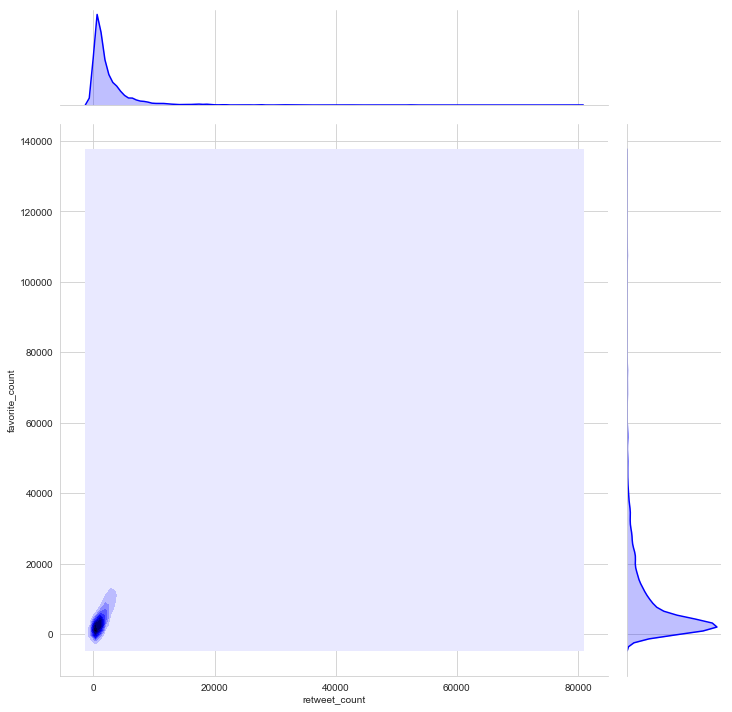

In [201]:
####################
###### CAMBIAR #####
####################

#Visualization comparing the favorite & retweet counts
sns.set_style('whitegrid')
g = sns.jointplot(x="retweet_count", 
                  y="favorite_count", 
                  data=df_merge, 
                  color="blue",
                  kind="kde", 
                  size=10)
g.plot_joint(plt.scatter,  
             c="black",
             s=80, 
             linewidth=1, 
             marker="+",
             alpha=0.45)
g.set_axis_labels("Retweet Count", "Favorite Count",fontsize=12)

g.fig.subplots_adjust(top=0.9)
sns.plt.suptitle('Is there a correlation between the retweet & favorite counts?',
                 fontsize=16)

#### **Reportando para este proyecto**
Cree un informe escrito de 300-600 palabras llamado wrangle_report.pdfo wrangle_report.htmlque describa brevemente sus esfuerzos de discusión. Esto debe ser enmarcado como un documento interno.

Cree un **informe escrito con un mínimo de 250 palabras** llamado act_report.pdf o act_report.htmlque comunique los conocimientos y muestre las visualizaciones producidas a partir de sus datos ordenados. Esto se debe enmarcar como un documento externo, como una publicación de blog o un artículo de una revista, por ejemplo.